Modelado Determinístico vs Modelado Probabilístico

(Comparación de Regresión Kernel Ridge y Procesos Gaussianos)


Basado en https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_compare_gpr_krr.html#sphx-glr-auto-examples-gaussian-process-plot-compare-gpr-krr-py y https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html

## 1. Datos

Se crea el conjunto de datos:

In [16]:
import numpy as np

# Crear una secuencia de 1,000 puntos igualmente espaciados entre 0 y 10
X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)

# Calcular la función x * sin(x) para cada uno de los puntos en X y aplastar la matriz resultante en una dimensión
y = np.squeeze(X * np.sin(X))

Se eligen aleatoriamente 6 datos para el entrenamiento.

In [17]:
rng = np.random.RandomState(1)

# Elige aleatoriamente 6 índices para el entrenamiento
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)

# Separa los 6 elementos para el entrenamiento
X_train, y_train = X[training_indices], y[training_indices]

# Crear un conjunto de prueba que contiene todos los elementos menos los de entrenamiento
test_indices = np.setdiff1d(np.arange(y.size), training_indices)

# Separar los elementos para el test
X_test, y_test = X[test_indices], y[test_indices]

Se visualizan los datos creados:

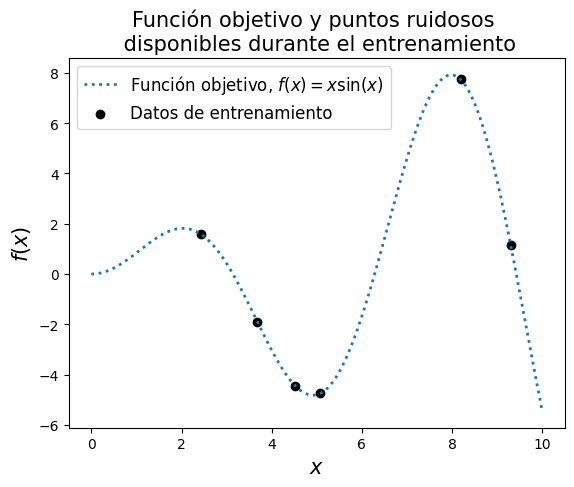

In [18]:
import matplotlib.pyplot as plt

# Dibuja la función objetivo sin ruido
plt.plot(X, y, label="Función objetivo, $f(x) = x \sin(x)$", linewidth=2, linestyle="dotted")

# Dibuja los 40 puntos de los datos con ruido
plt.scatter(
    X_train,
    y_train,
    color="black",
    label="Datos de entrenamiento",
)

# Leyenda
plt.legend(fontsize=12)

# Ejes
plt.xlabel("$x$", fontsize=15)
plt.ylabel("$f(x)$", fontsize=15)
_ = plt.title(
    "Función objetivo y puntos ruidosos \n disponibles durante el entrenamiento", fontsize=15
)

## 2. Limitaciones de un modelo lineal simple

En primer lugar, antes de usar kernels, se ven las claras limitaciones de un modelo lineal simple:

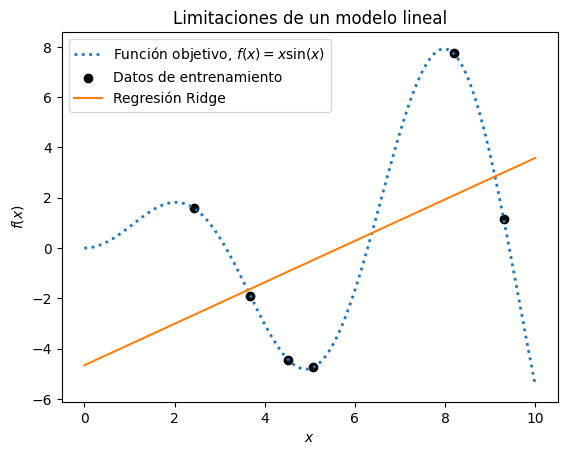

In [19]:
from sklearn.linear_model import Ridge

# Ajusta el modelo a los datos de entrenamiento y a las etiquetas objetivo correspondientes
ridge = Ridge().fit(X_train, y_train)

# Dibuja el verdadero comportamiento de los datos
plt.plot(X, y, label="Función objetivo, $f(x) = x \sin(x)$", linewidth=2, linestyle="dotted")

# Dibuja los datos de entrenamiento
plt.scatter(
    X_train,
    y_train,
    color="black",
    label="Datos de entrenamiento",
)

# Dibuja la predicción del modelo
plt.plot(X, ridge.predict(X), label="Regresión Ridge")

#Leyenda y ejes
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Limitaciones de un modelo lineal")

Obviamente no se puede ajustar correctamente a la función objetivo.

## 3. Regresión Kernel Ridge

Se va a hacer el modelo anterior más 'expresivo' con el uso de kernels. Un kernel es la incrustación del espacio de características original en otro, para mapear nuestros datos originales en un espacio de características más nuevo y complejo.

Usar este modelo junto con un kernel es equivalente a incrustar los datos utilizando la función de mapeo del kernel y posteriormente aplicar una Regresión Ridge. En la práctica, los datos no se mapean explícitamente; en su lugar, se calcula el producto escalar entre muestras en el espacio de características de mayor dimensión utilizando el "kernel trick".

En concreto se va a utilizar un kernel que ha sido ampliamente estudiado durante el TFG: el RBF (Radial Basis Function), o también conocido como Squared Exponential Kernel. Está parametrizado por un length-scale, que puede ser un escalar (variante isotrópica del kernel) o un vector con el mismo número de dimensiones que las entradas X (variante anisotrópica del kernel).


In [20]:
import time
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Declaro el modelo con un kernel RBF
kernel_RBF = RBF()
kernel_ridge = KernelRidge(kernel=kernel_RBF)

# Se cronometra el tiempo de entrenamiento
start_time = time.time()

# Se ajusta el modelo a los datos de entrenamiento
kernel_ridge.fit(X_train, y_train)

# Se muestra el tiempo transcurrido
print(f"Fitting KernelRidge with default kernel: {time.time() - start_time:.3f} seconds")

Fitting KernelRidge with default kernel: 0.003 seconds


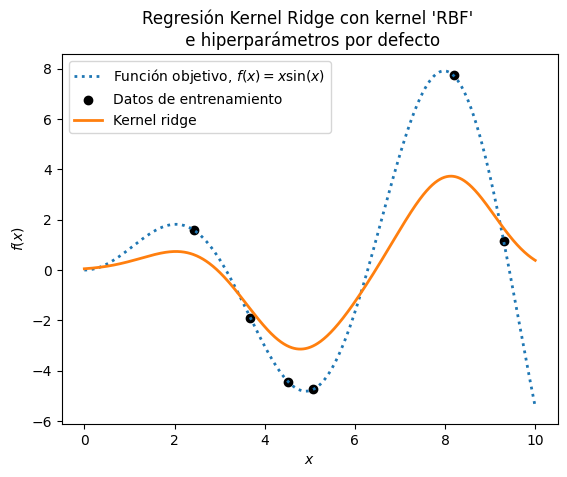

In [21]:
# Dibuja el verdadero comportamiento de los datos
plt.plot(X, y, label="Función objetivo, $f(x) = x \sin(x)$", linewidth=2, linestyle="dotted")

# Dibuja los datos de entrenamiento
plt.scatter(
    X_train,
    y_train,
    color="black",
    label="Datos de entrenamiento",
)

# Dibuja la predicción del modelo
plt.plot(
    X_test,
    kernel_ridge.predict(X_test),
    label="Kernel ridge",
    linewidth=2
)

# Leyenda y ejes
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title(
    "Regresión Kernel Ridge con kernel 'RBF' \n e hiperparámetros por defecto"
)

Los resultados siguen siendo malos. Hemos usado los parámetros del kernel con los valores por defecto. Vamos a inspeccionarlos:

In [22]:
kernel_ridge.kernel

RBF(length_scale=1)

Con el método RandomizedSearchCV se realiza la búsqueda aleatoria de los mejores hiperparámetros.

En la siguiente celda se buscan los mejores hiperparámetros, se ajusta el modelo con ellos y por último se realiza una predicción:

In [23]:
import time
import numpy as np
from scipy.stats import loguniform
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Crear un pipeline que incluye estandarización y el modelo con RBF
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalización de los datos
    ('kernel_ridge', KernelRidge(kernel=RBF()))
])

# Definir el espacio de búsqueda de hiperparámetros para RandomizedSearchCV
param_distributions = {
    "kernel_ridge__alpha": loguniform(1e-5, 1e2),
    "kernel_ridge__kernel__length_scale": loguniform(1e-2, 1e1)
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=250,  # Incrementar el número de iteraciones
    random_state=42,
    cv=3,  # Reducir el número de pliegues debido a pocos datos de entrenamiento
    n_jobs=-1,
    verbose=1
)

# Ajustar el modelo con la búsqueda de hiperparámetros
random_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros del RandomizedSearchCV
print("Best parameters found from RandomizedSearchCV: ", random_search.best_params_)

# Utilizar el mejor modelo encontrado
best_kernel_ridge = random_search.best_estimator_

# Predecir
y_pred = best_kernel_ridge.predict(X_test)

Fitting 3 folds for each of 250 candidates, totalling 750 fits
Best parameters found from RandomizedSearchCV:  {'kernel_ridge__alpha': 0.0015866892068163167, 'kernel_ridge__kernel__length_scale': 0.33551510227214826}


Nota: El parámetro "alpha" en el contexto de Kernel Ridge Regression es un hiperparámetro de regularización. Controla la fuerza de regularización aplicada al modelo para evitar el sobreajuste a los datos de entrenamiento. Cuanto mayor sea el valor de alpha, mayor será la penalización aplicada a los coeficientes del modelo, lo que puede conducir a una solución más suave y menos propensa al sobreajuste.

Se dibuja la nueva solución:

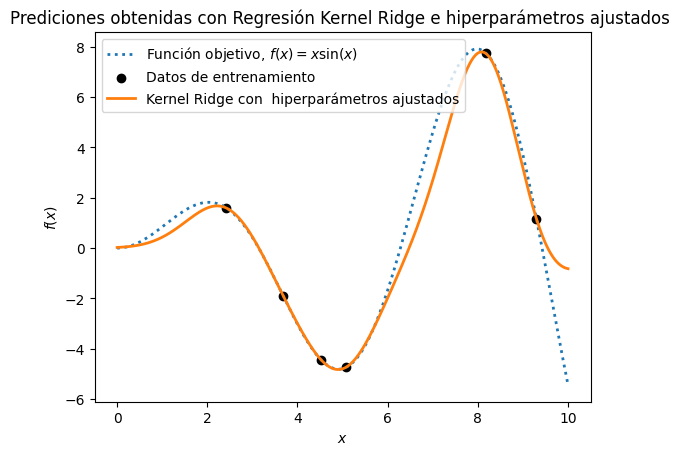

In [24]:
# Dibuja el verdadero comportamiento de los datos
plt.plot(X, y, label="Función objetivo, $f(x) = x \sin(x)$", linewidth=2, linestyle="dotted")

# Dibuja los datos de entrenamiento
plt.scatter(
    X_train,
    y_train,
    color="black",
    label="Datos de entrenamiento",
)

# Dibuja la predicción del modelo
plt.plot(
    X_test,
    y_pred,
    label="Kernel Ridge con  hiperparámetros ajustados",
    linewidth=2
)

# Leyenda y ejes
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title(
    "Prediciones obtenidas con Regresión Kernel Ridge e hiperparámetros ajustados "
)

Ahora ya se obtiene una solución mucho más acertada.

Añado un gráfico con todas las soluciones superpuestas:

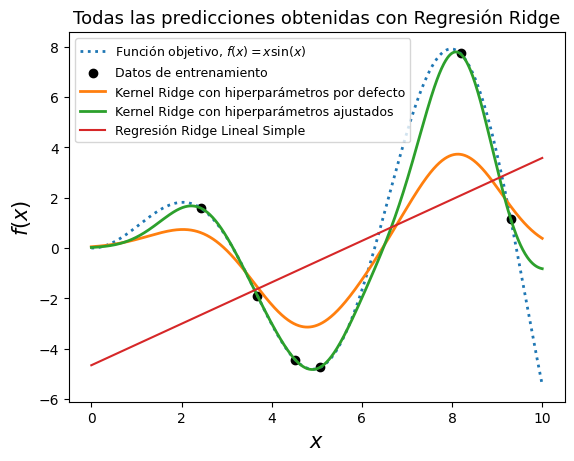

In [25]:
# Dibuja el verdadero comportamiento de los datos
plt.plot(X, y, label="Función objetivo, $f(x) = x \sin(x)$", linewidth=2, linestyle="dotted")

# Dibuja los datos de entrenamiento
plt.scatter(
    X_train,
    y_train,
    color="black",
    label="Datos de entrenamiento",
)

# Dibuja la predicción del modelo (Por defecto)
plt.plot(
    X_test,
    kernel_ridge.predict(X_test),
    label="Kernel Ridge con hiperparámetros por defecto",
    linewidth=2
)

# Dibuja la predicción del modelo
plt.plot(
    X_test,
    y_pred,
    label="Kernel Ridge con hiperparámetros ajustados",
    linewidth=2
)

# Dibuja la predicción del modelo
plt.plot(X, ridge.predict(X), label="Regresión Ridge Lineal Simple")

# Leyenda y ejes
plt.legend(fontsize=9)
plt.xlabel("$x$", fontsize=15)
plt.ylabel("$f(x)$", fontsize=15)
_ = plt.title(
    "Todas las predicciones obtenidas con Regresión Ridge", fontsize=13
)

## 4. Procesos Gaussianos

Ahora probaremos ajustar a la función 'target' con Procesos Gaussianos a partir de los datos de entrenamiento, utilizando también un kernel RBF.

No es necesaria una búsqueda de hiperparámetros, ya que con la clase GaussianProcessRegressor estos se ajustan durante el entrenamiento (con el método 'fit').

In [26]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Se toma tiempo y se ajusta el modelo
start_time = time.time()
gaussian_process.fit(X_train, y_train)
print(
    f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds"
)

gaussian_process.kernel_

Time for GaussianProcessRegressor fitting: 0.172 seconds


5.02**2 * RBF(length_scale=1.43)

El coste computacional del Proceso Gaussiano es mucho menor que el de la regresión Ridge con la búsqueda aleatoria de los mejores hiperparámetros.

Los parámetros del Proceso Gaussiano son los siguientes:


In [27]:
gaussian_process.kernel_

5.02**2 * RBF(length_scale=1.43)

In [28]:
# Cabe destacar que el Proceso Gaussiano da probabilidades, con ellas se hace la media:
start_time = time.time()
mean_predictions_gpr, std_predictions_gpr = gaussian_process.predict(
    X_test,
    return_std=True,
)
print(
    f"Time for GaussianProcessRegressor predict: {time.time() - start_time:.3f} seconds"
)

Time for GaussianProcessRegressor predict: 0.007 seconds


Ahora dibujamos las predicciones obtenidas con Procesos Gaussianos:


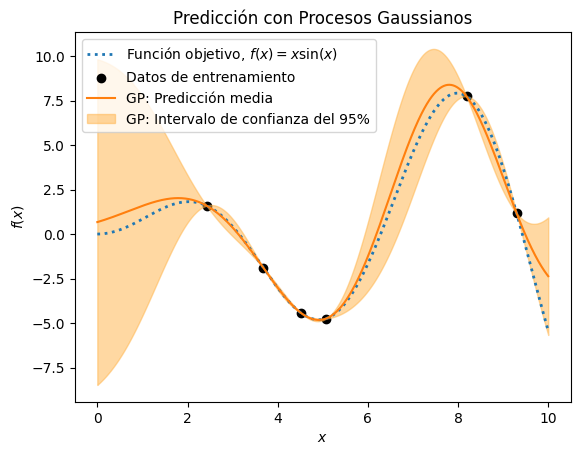

In [29]:
mean_prediction, std_prediction = gaussian_process.predict(X_test, return_std=True)

# Dibuja el verdadero comportamiento de los datos
plt.plot(X, y, label="Función objetivo, $f(x) = x \sin(x)$", linewidth=2, linestyle="dotted")

# Dibuja los datos de entrenamiento
plt.scatter(
    X_train,
    y_train,
    color="black",
    label="Datos de entrenamiento",
)

# Dibuja la predicción media con Procesos Gaussianos
plt.plot(X_test, mean_prediction, label="GP: Predicción media")

# Dibuja un intervalo de confianza del 95% con Procesos Gaussianos
plt.fill_between(
    X_test.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"GP: Intervalo de confianza del 95%",
    color='#FFB347',  # Color naranja pastel
)

# Leyenda y ejes
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Predicción con Procesos Gaussianos")

Por último hacemos un gráfico conjunto de las predicciones de GP y Kernel Ridge:

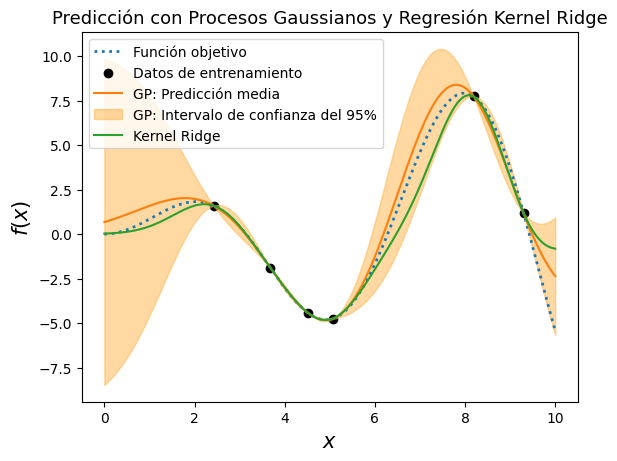

In [30]:
mean_prediction, std_prediction = gaussian_process.predict(X_test, return_std=True)

# Dibuja el verdadero comportamiento de los datos
plt.plot(X, y, label="Función objetivo", linewidth=2, linestyle="dotted")

# Dibuja los datos de entrenamiento
plt.scatter(
    X_train,
    y_train,
    color="black",
    label="Datos de entrenamiento",
)

# Dibuja la predicción media con Procesos Gaussianos
plt.plot(X_test, mean_prediction, label="GP: Predicción media")

# Dibuja un intervalo de confianza del 95% con Procesos Gaussianos
plt.fill_between(
    X_test.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"GP: Intervalo de confianza del 95%",
    color='#FFB347',  # Color naranja pastel
)

# Dibuja la predicción del modelo Kernel Ridge
plt.plot(
    X_test,
    #predictions_kr,
    y_pred,
    label="Kernel Ridge"
)

# Leyenda y ejes
plt.legend()
plt.xlabel("$x$", fontsize=15)
plt.ylabel("$f(x)$", fontsize=15)
_ = plt.title("Predicción con Procesos Gaussianos y Regresión Kernel Ridge", fontsize=13)

## 5. Conclusiones

Utilizando como entrenamiento únicamente 6 puntos del conjunto de datos, hemos podido predecir con cierta facilidad la función objetivo.

Los resultados son bastante similares en ambos intentos. La mayor diferencia está en la incertidumbre que los Procesos Gaussianos son capaces de mostrar, ya que por la formulación probabilística de la función objetivo se puede dar la predicción media junto a la desviación típica. Esto nos puede ser de gran ayuda en determinadas situaciones.


<mark> DUDA: "However, it comes at a cost: the time to compute the predictions is higher with a Gaussian process." </mark>

¿¿Pero no hemos visto que la búsqueda de hiperparámetros era mucho más costosa en la Regresión Ridge con el Kernel??